In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsF_0008.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.23531368, 42.4853645)>


In [3]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2V Reduced')
file1 = 'reduceducdF_0008.fits'
image1 = pf.getdata(file1)
file2 = 'reduceducdF_0009.fits'
image2 = pf.getdata(file2)
image = image1+image2

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[456.64520786 630.56197942 426.08621357 256.75150074 325.33754816
 279.55276918 615.91102688 653.70122709 691.99849188 561.43176272]
[310.20534392 295.24245241 140.99408331 463.54850574 131.76343443
 377.47352154 142.43785416 361.35645675 477.79938879 550.30887149]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag   
--- --------- --------- ---------- ... --- --------- --------- ---------
229 454.66505   306.663 0.87597255 ...   0 452.73694 52.214557 -4.294479
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
219 629.76319 292.26552 0.90645784 ...   0 281.17693 31.681955 -3.7520299
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
 93 425.47196 140.19313 0.82107571 ...   0 4796.5728 586.52259 -6.9207119
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag  

In [4]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=3) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.99368429 -24.36429162]
[[ 0.00014895 -0.0016506 ]
 [-0.0016506   0.0185567 ]]
Beta: [  0.93967804 -23.70110809]
Beta Std Error: [0.01716711 0.23856845]
Beta Covariance: [[ 5.55532107e-05 -7.64321880e-04]
 [-7.64321880e-04  1.07285481e-02]]
Residual Variance: 5.304995967379151
Inverse Condition #: 0.05591018133446116
Reason(s) for Halting:
  Sum of squares convergence


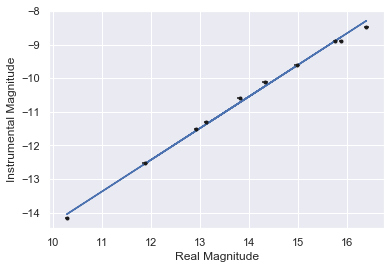

In [5]:
mags = np.array(mags)
realmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.323,11.868,14.98]
realmag = np.array(realmag)
realmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [6]:
xref = 403
yref = 376

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
428 560.11799 549.32998   0.943534 ...   0 1081.3266 118.85404 -5.1875349
293 402.04991   376.152 0.66099891 ...   0 101438.19 14857.102 -10.429835
299 394.40758 383.54168 0.79012648 ...   0  81.18052  3.991237 -1.5027688


In [7]:
sourcemag = []
sourcemagerror = []
position = [(402.04991,376.152)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-14.733767363883274]


In [8]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

9.542992800698057 +/- 0.30798310612549284


In [12]:
sourcemag = []
position = [(560.11799,549.32998)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-9.596529288593164]


In [13]:
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0])

15.00347740784173


In [1]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z)

[[82.150936, 42.449436], [82.110034, 42.452321], [82.158453, 42.478781], [82.197666, 42.42245], [82.182192, 42.480211], [82.192476, 42.437444], [82.113757, 42.478844], [82.104471, 42.440872], [82.095256, 42.420703], [82.125836, 42.407897]]


In [2]:
x = [82.183071,82.177918,82.134288,82.192476,82.156488,82.129231]
y = [42.446424,42.454144,42.438220,42.437444,42.416215,42.421826]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z)

[[82.183071, 42.446424], [82.177918, 42.454144], [82.134288, 42.43822], [82.192476, 42.437444], [82.156488, 42.416215], [82.129231, 42.421826]]


In [3]:
x = [82.210469,82.197666,82.192476,82.222068,82.183071,82.177918,82.207615,82.150936,82.273604,82.293393,082.227526]
y = [42.440152,42.422450,42.437444,42.444300,42.446424,42.454144,42.472578,42.449436,42.398775,42.422490,42.371688]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z)

[[82.210469, 42.440152], [82.197666, 42.42245], [82.192476, 42.437444], [82.222068, 42.4443], [82.183071, 42.446424], [82.177918, 42.454144], [82.207615, 42.472578], [82.150936, 42.449436], [82.273604, 42.398775], [82.293393, 42.42249], [82.227526, 42.371688]]


In [ ]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]